In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math



In [57]:
# --- 1. Carga de Datos y Limpieza Inicial ---

# Cargar el dataset
# Consideración: Asegúrate de que 'traffic_accidents_clean.csv' esté en la misma ruta
# o proporciona la ruta completa al archivo.
df_accidentes = pd.read_csv("traffic_accidents_clean.csv", index_col="num_expediente")

# Renombrar columnas para mayor claridad y consistencia (opcional, pero buena práctica)
df_accidentes = df_accidentes.rename(columns={
    'coordenada_x_utm': 'coordenada_x',
    'coordenada_y_utm': 'coordenada_y'
})

# Convertir columna 'fecha' a tipo datetime
df_accidentes['fecha'] = pd.to_datetime(df_accidentes["fecha"])

# Extraer el año del accidente
df_accidentes['año'] = df_accidentes['fecha'].dt.year

# --- 2. Gestión de Datos Faltantes (NaN) ---

# Rellenar valores faltantes con la moda para columnas categóricas
columnas_moda = ['rango_edad', 'sexo', 'lesividad', 'condiciones_meteorológicas']
mapeo_reemplazo = {
    'rango_edad': 'Desconocido',
    'sexo': 'Desconocido',
    'lesividad': 'Se desconoce',
    'condiciones_meteorológicas': 'No registrado'
}

for columna in columnas_moda:
    if columna in df_accidentes.columns:
        # Reemplazar valores específicos por NaN primero
        if columna in mapeo_reemplazo:
            df_accidentes[columna] = df_accidentes[columna].replace(mapeo_reemplazo[columna], np.nan)
        
        # Calcular la moda y rellenar NaN
        moda_valor = df_accidentes[columna].mode()[0]
        df_accidentes[columna] = df_accidentes[columna].fillna(moda_valor)

# Rellenar valores faltantes con la media para columnas numéricas (coordenadas)
df_accidentes['coordenada_x'] = df_accidentes['coordenada_x'].fillna(df_accidentes['coordenada_x'].mean())
df_accidentes['coordenada_y'] = df_accidentes['coordenada_y'].fillna(df_accidentes['coordenada_y'].mean())

# --- 3. Eliminación de Duplicados ---
df_accidentes.drop_duplicates(inplace=True)


In [58]:


# --- 4. Cálculo de Muertes y Franjas Horarias ---

# Crear columna 'es_mortal' (Booleano) y 'num_muertes' (Numérico)
df_accidentes['es_mortal'] = (df_accidentes['lesividad'] == "Fallecido 24 horas")
df_accidentes['num_muertes'] = df_accidentes['es_mortal'].astype(int) # Convertir Booleano a 0 o 1

# Calcular muertes anuales
muertes_anuales = df_accidentes.groupby("año")['num_muertes'].sum().reset_index()

# Función para asignar franjas horarias
def obtener_franja_horaria(hora):
    if 0 <= hora < 7:
        return "Madrugada"
    elif 7 <= hora < 12:
        return "Mañana"
    elif 12 <= hora < 19:
        return "Tarde"
    else:
        return "Noche"

# Extraer la hora en formato entero
df_accidentes['hora_entera'] = df_accidentes['hora_24h'].str.split(':').str[0].astype(int)

# Crear nueva columna 'franja_horaria'
df_accidentes['franja_horaria'] = df_accidentes['hora_entera'].apply(obtener_franja_horaria)

# Agrupar muertes por año y franja horaria
muertes_por_año_y_franja = df_accidentes.groupby(['año', 'franja_horaria'])['num_muertes'].sum().reset_index()

# Opcional: definir un orden lógico para la columna 'franja_horaria' para gráficos
orden_franjas_horarias = ["Madrugada", "Mañana", "Tarde", "Noche"]
muertes_por_año_y_franja['franja_horaria'] = pd.Categorical(
    muertes_por_año_y_franja['franja_horaria'],
    categories=orden_franjas_horarias,
    ordered=True
)

# Calcular porcentaje de muertes por franja horaria anual
total_muertes_por_año_para_pct = muertes_por_año_y_franja.groupby('año')['num_muertes'].transform('sum')
muertes_por_año_y_franja['pct_muertes_anual'] = (muertes_por_año_y_franja['num_muertes'] / total_muertes_por_año_para_pct) * 100

# Encontrar la franja horaria con mayor porcentaje de muertes por cada año
idx_max_franja_anual = muertes_por_año_y_franja.groupby('año')['pct_muertes_anual'].idxmax()
franja_horaria_mas_mortal_anual = muertes_por_año_y_franja.loc[idx_max_franja_anual].reset_index(drop=True)
muertes_anuales

,año,num_muertes
0,2019,34
1,2020,34
2,2021,28
3,2022,22
4,2023,26


In [36]:

# --- 5. Análisis por Tipo de Accidente ---

# % de muertes por tipo de accidente dentro de cada año
muertes_anuales_por_tipo_accidente = df_accidentes.groupby(['año', 'tipo_accidente'])['num_muertes'].sum().reset_index()
total_muertes_anuales_acc = muertes_anuales_por_tipo_accidente.groupby('año')['num_muertes'].transform('sum')
muertes_anuales_por_tipo_accidente['pct_tasa_mortalidad_anual'] = (muertes_anuales_por_tipo_accidente['num_muertes'] / total_muertes_anuales_acc) * 100

# Tipo de accidente con mayor % muertes por año
idx_max_tipo_acc_anual = muertes_anuales_por_tipo_accidente.groupby('año')["pct_tasa_mortalidad_anual"].idxmax()
tipo_accidente_mas_mortal_anual = muertes_anuales_por_tipo_accidente.loc[idx_max_tipo_acc_anual].reset_index(drop=True)

# Tasa mortalidad total por tipo de accidente (muertes / total accidentes de ese tipo)
total_ocurrencias_tipo_accidente = df_accidentes['tipo_accidente'].value_counts()
muertes_por_tipo_accidente_total = df_accidentes.groupby('tipo_accidente')['num_muertes'].sum()
tasa_mortalidad_por_tipo_accidente = (muertes_por_tipo_accidente_total / total_ocurrencias_tipo_accidente) * 100

# Proporción de muertes totales por tipo de accidente (%)
total_general_muertes_acc = muertes_por_tipo_accidente_total.sum()
proporcion_muertes_por_tipo_accidente = (muertes_por_tipo_accidente_total / total_general_muertes_acc) * 100
tipo_accidente_mas_mortal_anual

,año,tipo_accidente,num_muertes,pct_tasa_mortalidad_anual
0,2019,Atropello a persona,15,44.117647
1,2020,Atropello a persona,13,38.235294
2,2021,Atropello a persona,9,32.142857
3,2022,Atropello a persona,9,40.909091
4,2023,Atropello a persona,12,46.153846


In [ ]:


# --- 6. Análisis por Tipo de Vehículo ---

# % de muertes por tipo de vehículo dentro de cada año
muertes_anuales_por_tipo_vehiculo = df_accidentes.groupby(['año', 'tipo_vehiculo'])['num_muertes'].sum().reset_index()
total_muertes_anuales_veh = muertes_anuales_por_tipo_vehiculo.groupby('año')['num_muertes'].transform('sum')
muertes_anuales_por_tipo_vehiculo['tasa_mortalidad_anual'] = (muertes_anuales_por_tipo_vehiculo['num_muertes'] / total_muertes_anuales_veh) * 100

# Tasa mortalidad total por vehículo (muertes / total accidentes de ese vehículo)
total_ocurrencias_tipo_vehiculo = df_accidentes['tipo_vehiculo'].value_counts()
muertes_por_tipo_vehiculo_total = df_accidentes.groupby('tipo_vehiculo')['num_muertes'].sum()
tasa_mortalidad_por_tipo_vehiculo = (muertes_por_tipo_vehiculo_total / total_ocurrencias_tipo_vehiculo) * 100

# Proporción de muertes totales por vehículo (%)
total_general_muertes_veh = muertes_por_tipo_vehiculo_total.sum()
proporcion_muertes_por_tipo_vehiculo = (muertes_por_tipo_vehiculo_total / total_general_muertes_veh) * 100


tipo_vehiculo
Ambulancia SAMUR                     0.000000
Autobus EMT                          0.000000
Autobús                              0.126081
Autobús articulado                   0.000000
Autobús articulado EMT               0.000000
Autocaravana                         0.000000
Bicicleta                            0.132170
Bicicleta EPAC (pedaleo asistido)    0.000000
Camión de bomberos                   0.000000
Camión rígido                        0.039216
Caravana                             0.000000
Ciclo                                0.000000
Ciclo de motor L1e-A                 0.000000
Ciclomotor                           0.094458
Ciclomotor de dos ruedas L1e-B       0.000000
Ciclomotor de tres ruedas            0.000000
Cuadriciclo ligero                   0.000000
Cuadriciclo no ligero                0.000000
Furgoneta                            0.035443
Maquinaria agrícola                  0.000000
Maquinaria de obras                  0.000000
Microbús <= 17 plaza

In [44]:

# --- 7. Análisis por Distrito ---

# % de muertes por distrito dentro de cada año
muertes_anuales_por_distrito = df_accidentes.groupby(['año', 'distrito'])['num_muertes'].sum().reset_index()
total_muertes_anuales_dist = muertes_anuales_por_distrito.groupby('año')['num_muertes'].transform('sum')
muertes_anuales_por_distrito['pct_tasa_mortalidad_anual'] = (muertes_anuales_por_distrito['num_muertes'] / total_muertes_anuales_dist) * 100

# Distrito con mayor % muertes por año
idx_max_distrito_anual = muertes_anuales_por_distrito.groupby('año')["pct_tasa_mortalidad_anual"].idxmax()
distrito_mas_mortal_anual = muertes_anuales_por_distrito.loc[idx_max_distrito_anual].reset_index(drop=True)

# Tasa mortalidad total por distrito (muertes / total accidentes en el distrito)
total_ocurrencias_distrito = df_accidentes['distrito'].value_counts()
muertes_por_distrito_total = df_accidentes.groupby('distrito')['num_muertes'].sum()
tasa_mortalidad_por_distrito = (muertes_por_distrito_total / total_ocurrencias_distrito) * 100

# Proporción de muertes totales por distrito (%)
total_general_muertes_dist = muertes_por_distrito_total.sum()
proporcion_muertes_por_distrito = (muertes_por_distrito_total / total_general_muertes_dist) * 100

tasa_mortalidad_por_distrito

distrito
Arganzuela             0.072622
Barajas                0.026062
Carabanchel            0.022365
Centro                 0.094959
Chamartín              0.047109
Chamberí               0.077783
Ciudad Lineal          0.065355
Fuencarral-El Pardo    0.116917
Hortaleza              0.085543
Latina                 0.080144
Moncloa-Aravaca        0.142564
Moratalaz              0.067408
Puente De Vallecas     0.054263
Retiro                 0.045960
Salamanca              0.044237
San Blas-Canillejas    0.045483
Tetuán                 0.086515
Usera                  0.071225
Vicálvaro              0.029053
Villa De Vallecas      0.070361
Villaverde             0.074850
dtype: float64

In [52]:

# --- 8. Análisis por Rango de Edad ---

# % de muertes por rango_edad dentro de cada año
muertes_anuales_por_rango_edad = df_accidentes.groupby(['año', 'rango_edad'])['num_muertes'].sum().reset_index()
total_muertes_anuales_edad = muertes_anuales_por_rango_edad.groupby('año')['num_muertes'].transform('sum')
muertes_anuales_por_rango_edad['pct_tasa_mortalidad_anual'] = (muertes_anuales_por_rango_edad['num_muertes'] / total_muertes_anuales_edad) * 100

# Rango de edad con mayor % muertes por año
idx_max_edad_anual = muertes_anuales_por_rango_edad.groupby('año')["pct_tasa_mortalidad_anual"].idxmax()
rango_edad_mas_mortal_anual = muertes_anuales_por_rango_edad.loc[idx_max_edad_anual].reset_index(drop=True)

# Tasa mortalidad total por rango_edad (muertes / total accidentes en el rango_edad)
total_ocurrencias_rango_edad = df_accidentes['rango_edad'].value_counts()
muertes_por_rango_edad_total = df_accidentes.groupby('rango_edad')['num_muertes'].sum()
tasa_mortalidad_por_rango_edad = (muertes_por_rango_edad_total / total_ocurrencias_rango_edad) * 100

# Proporción de muertes totales por rango de edad (%)
total_general_muertes_edad = muertes_por_rango_edad_total.sum()
proporcion_muertes_por_rango_edad = (muertes_por_rango_edad_total / total_general_muertes_edad) * 100

# Definir el orden lógico de los rangos de edad (crucial para gráficos)
# Asegúrate de que esta lista refleje todos los rangos exactos de tu dataset
orden_rangos_edad = [
    '0 - 4', '5 - 9', '10 - 14', '15 - 17', '18 - 20', '21 - 24', '25 - 29',
    '30 - 34', '35 - 39', '40 - 44', '45 - 49', '50 - 54', '55 - 59',
    '60 - 64', '65 - 69', '70 - 74', '75+'
]
# Convertir el índice de la serie a tipo categórico con el orden definido
tasa_mortalidad_por_rango_edad.index = pd.CategoricalIndex(
    tasa_mortalidad_por_rango_edad.index, categories=orden_rangos_edad, ordered=True
)
# Eliminar NaN y ordenar según el índice categórico
tasa_mortalidad_por_rango_edad = tasa_mortalidad_por_rango_edad.sort_index().dropna()
tasa_mortalidad_por_rango_edad

rango_edad
0 - 4      0.145349
10 - 14    0.049826
15 - 17    0.000000
18 - 20    0.045551
21 - 24    0.054968
25 - 29    0.057456
30 - 34    0.026752
35 - 39    0.087910
40 - 44    0.032276
45 - 49    0.061107
50 - 54    0.054505
55 - 59    0.054359
60 - 64    0.135685
65 - 69    0.108483
70 - 74    0.158831
75+        0.504838
NaN        0.000000
dtype: float64

In [61]:
# --- 9. Análisis por Condiciones Meteorológicas ---

# % de muertes en cada tipo de clima dentro de cada año.
muertes_anuales_por_clima = df_accidentes.groupby(['año', 'condiciones_meteorológicas'])['num_muertes'].sum().reset_index()
total_muertes_anuales_clima = muertes_anuales_por_clima.groupby('año')['num_muertes'].transform('sum')
muertes_anuales_por_clima['tasa_mortalidad_anual'] = (muertes_anuales_por_clima['num_muertes'] / total_muertes_anuales_clima) * 100

# Clima con mayor % muertes por año
idx_max_clima_anual = muertes_anuales_por_clima.groupby('año')["tasa_mortalidad_anual"].idxmax()
clima_mas_mortal_anual = muertes_anuales_por_clima.loc[idx_max_clima_anual].reset_index(drop=True)

# Tasa mortalidad total por clima (muertes / total accidentes bajo esa condición)
total_ocurrencias_clima = df_accidentes['condiciones_meteorológicas'].value_counts()
muertes_por_clima_total = df_accidentes.groupby('condiciones_meteorológicas')['num_muertes'].sum()
tasa_mortalidad_por_clima = (muertes_por_clima_total / total_ocurrencias_clima) * 100

# Proporción de muertes totales por clima (%)
total_general_muertes_clima = muertes_por_clima_total.sum()
proporcion_muertes_por_clima = (muertes_por_clima_total / total_general_muertes_clima) * 100
tasa_mortalidad_por_clima

condiciones_meteorológicas
Despejado         0.066223
Granizando        0.000000
LLuvia intensa    0.069109
Lluvia débil      0.041095
Nevando           0.000000
Nublado           0.124430
dtype: float64

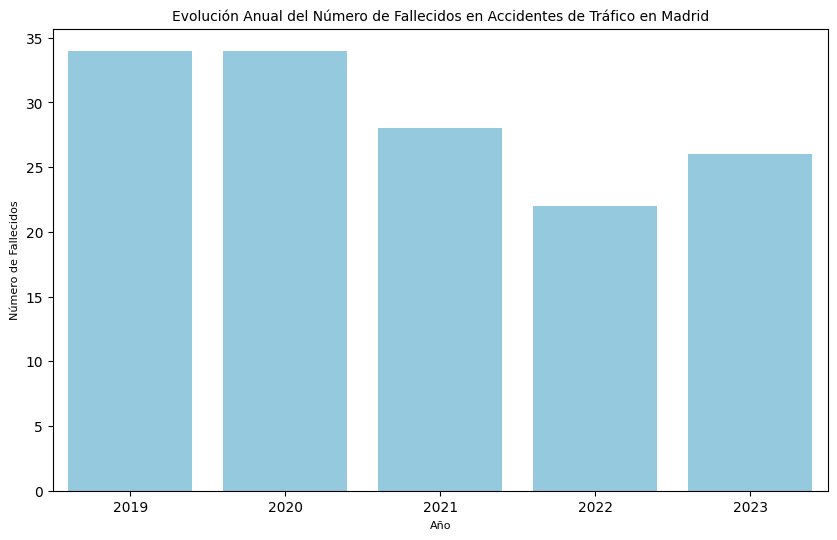

In [55]:

# --- 10. Visualizaciones ---

plt.figure(figsize=(10, 6))

# Usamos sns.barplot como antes
ax = sns.barplot(data=muertes_anuales, x='año', y='num_muertes', color='skyblue') 

# Título mejorado y más descriptivo
plt.title("Evolución Anual del Número de Fallecidos en Accidentes de Tráfico en Madrid", fontsize=10) 

# Etiquetas de los ejes mejoradas
plt.ylabel("Número de Fallecidos", fontsize=8)
plt.xlabel("Año", fontsize=8)
plt.show()

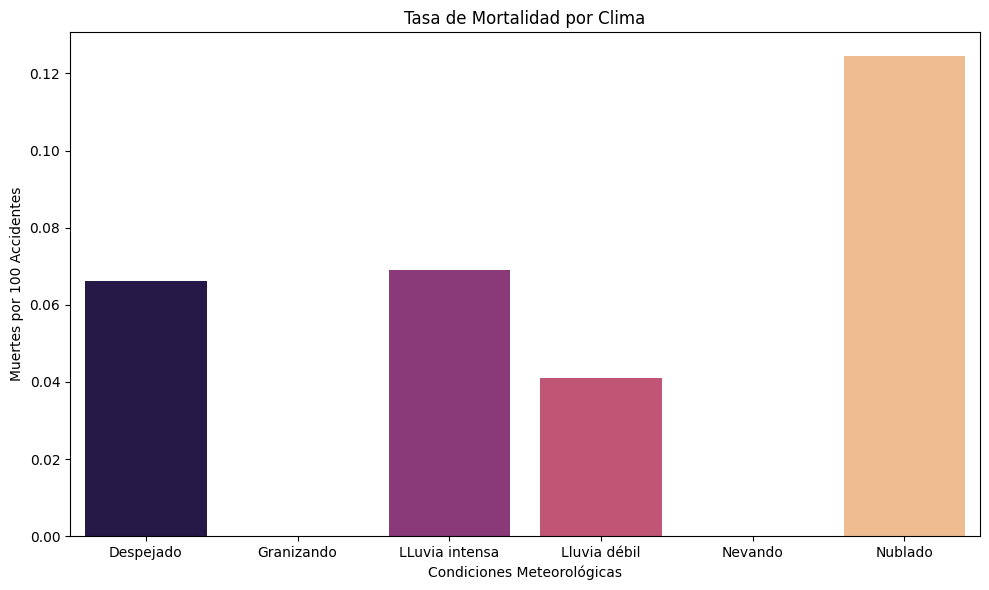

In [22]:


# 10.2. Tasa de Mortalidad por 100 Accidentes por Condición Climática 

plt.figure(figsize=(10, 6))
sns.barplot(
    x=tasa_mortalidad_por_clima.index,
    y=tasa_mortalidad_por_clima.values,
    palette="magma" , hue=tasa_mortalidad_por_clima.index
)
plt.title('Tasa de Mortalidad por Clima')
plt.xlabel('Condiciones Meteorológicas')
plt.ylabel('Muertes por 100 Accidentes')
plt.tight_layout()
plt.show()



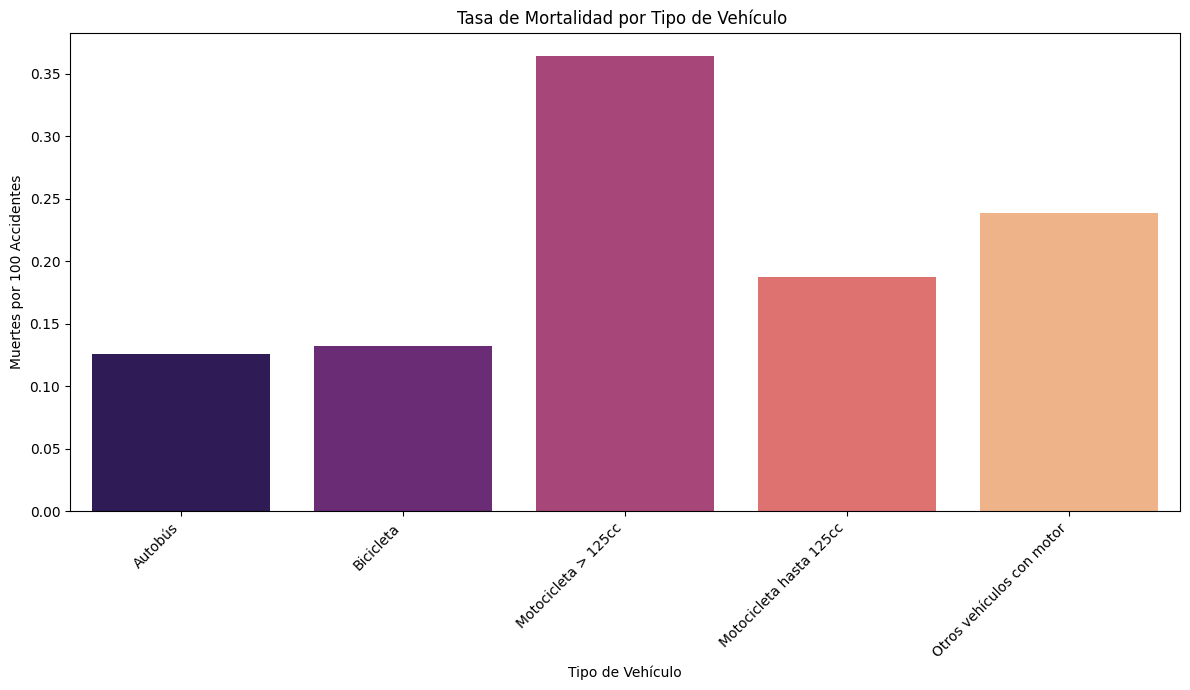

In [28]:
# 10.3. Tasa de Mortalidad por 100 Accidentes por Tipo de Vehículo (Filtrado)
tasa_mortalidad_vehiculo_filtrado = tasa_mortalidad_por_tipo_vehiculo.dropna()
tasa_mortalidad_vehiculo_filtrado = tasa_mortalidad_vehiculo_filtrado[tasa_mortalidad_vehiculo_filtrado > 0.1] # Ajusta este umbral si es necesario

plt.figure(figsize=(12, 7))
sns.barplot(
    x=tasa_mortalidad_vehiculo_filtrado.index,
    y=tasa_mortalidad_vehiculo_filtrado.values,
    palette='magma' ,hue=tasa_mortalidad_vehiculo_filtrado.index
)
plt.title('Tasa de Mortalidad por Tipo de Vehículo ')
plt.xlabel('Tipo de Vehículo')
plt.ylabel('Muertes por 100 Accidentes')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

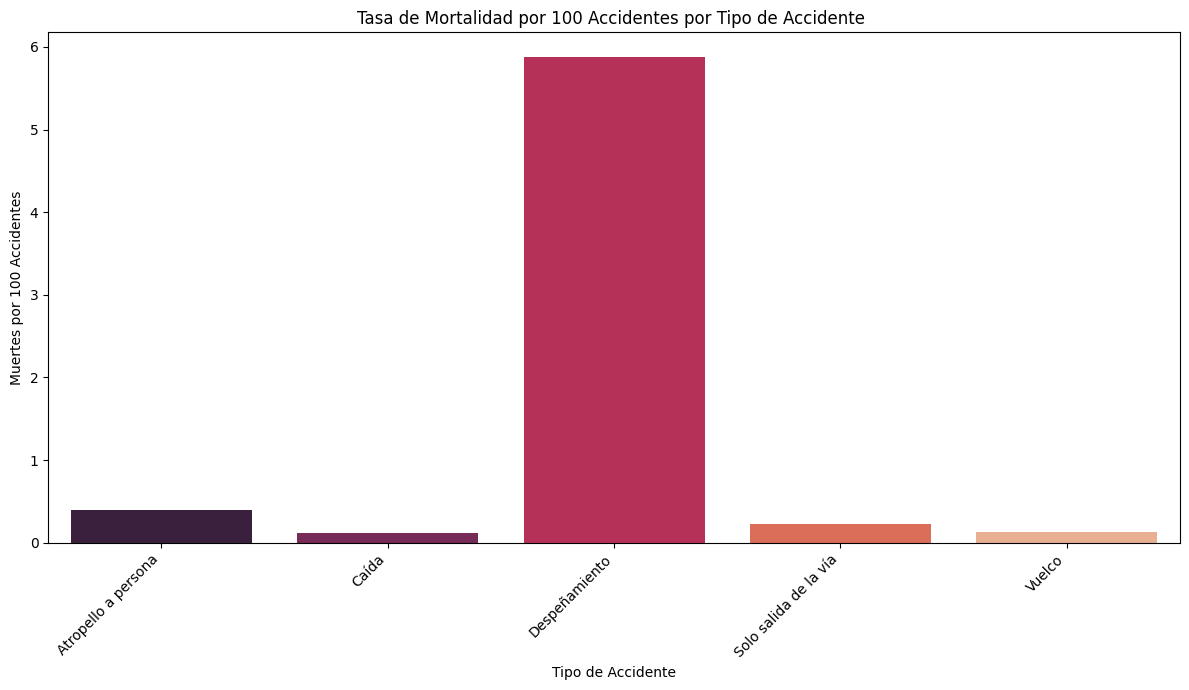

In [32]:
# 10.4. Tasa de Mortalidad por 100 Accidentes por Tipo de Accidente (Filtrado)
# Se recomienda usar .dropna() antes de filtrar por valor
tasa_mortalidad_accidente_filtrado = tasa_mortalidad_por_tipo_accidente.dropna()
tasa_mortalidad_accidente_filtrado = tasa_mortalidad_accidente_filtrado[tasa_mortalidad_accidente_filtrado > 0.1] # Ajusta este umbral

plt.figure(figsize=(12, 7))
sns.barplot(
    x=tasa_mortalidad_accidente_filtrado.index,
    y=tasa_mortalidad_accidente_filtrado.values,
    palette='rocket',hue=tasa_mortalidad_accidente_filtrado.index
)
plt.title('Tasa de Mortalidad por 100 Accidentes por Tipo de Accidente ')
plt.xlabel('Tipo de Accidente')
plt.ylabel('Muertes por 100 Accidentes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



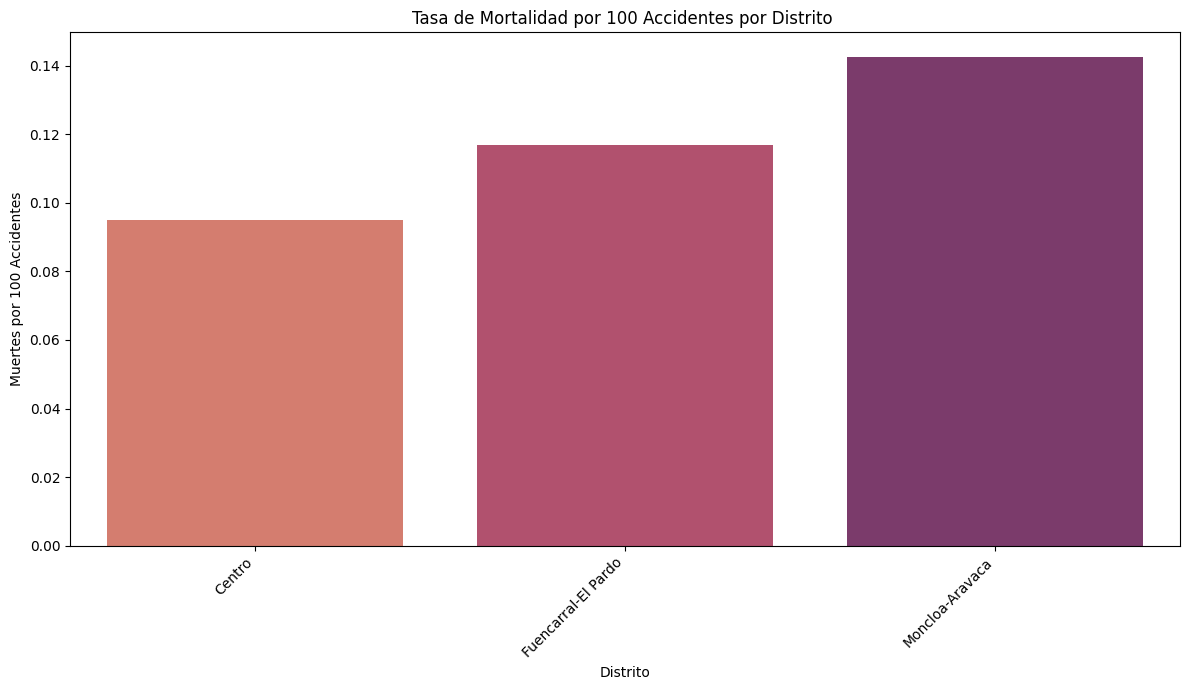

In [37]:

# 10.6. Tasa de Mortalidad por 100 Accidentes por Distrito (Filtrado)
tasa_mortalidad_distrito_filtrado = tasa_mortalidad_por_distrito.dropna()
tasa_mortalidad_distrito_filtrado = tasa_mortalidad_distrito_filtrado[tasa_mortalidad_distrito_filtrado > 0.09] # Ajusta este umbral

plt.figure(figsize=(12, 7))
sns.barplot(
    x=tasa_mortalidad_distrito_filtrado.index,
    y=tasa_mortalidad_distrito_filtrado.values,
    palette='flare', hue=tasa_mortalidad_distrito_filtrado.index
)
plt.title('Tasa de Mortalidad por 100 Accidentes por Distrito ')
plt.xlabel('Distrito')
plt.ylabel('Muertes por 100 Accidentes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


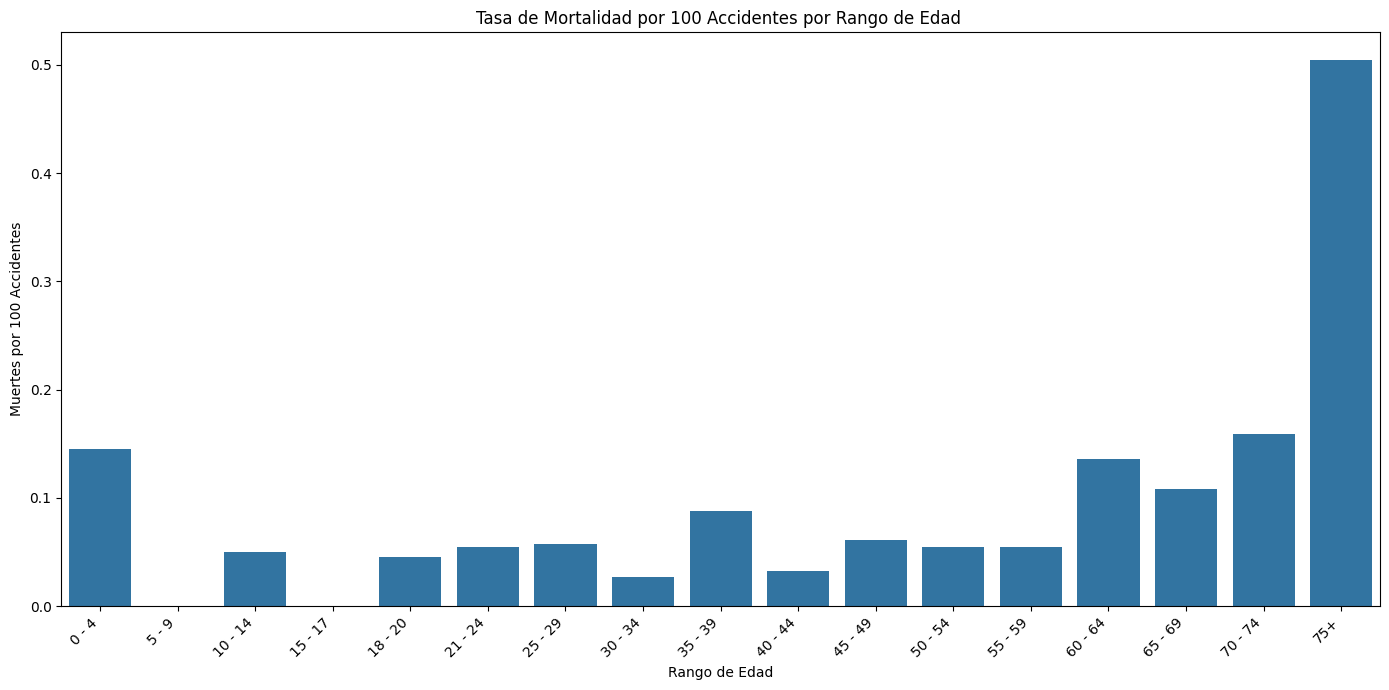

In [53]:
# 10.7. Tasa de Mortalidad por 100 Accidentes por Rango de Edad (Ordenado)
plt.figure(figsize=(14, 7))
sns.barplot(x=tasa_mortalidad_por_rango_edad.index, y=tasa_mortalidad_por_rango_edad.values)
plt.title('Tasa de Mortalidad por 100 Accidentes por Rango de Edad ')
plt.xlabel('Rango de Edad')
plt.ylabel('Muertes por 100 Accidentes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()